## Deep Convolutional Generative Adversarial Network (DCGAN)

Paper: [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434v2)

Helpful Resources:
- [Aladdin Persson's playlist on GANs](https://youtube.com/playlist?list=PLhhyoLH6IjfwIp8bZnzX8QR30TRcHO8Va&si=8ooImkbbXhCUC1xB)
- [GANs specialization on Coursera](https://www.coursera.org/specializations/generative-adversarial-networks-gans)
- [Stanford's Deep Generative Models playlist](https://youtube.com/playlist?list=PLoROMvodv4rPOWA-omMM6STXaWW4FvJT8&si=N_TpTe1bPIhte-t8)
- [AssemblyAI's GAN tutorial](https://youtu.be/_pIMdDWK5sc?si=Mtx2oWh1ZO9tqWYg)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.manual_seed(0)

print("Imports done!")

Imports done!


In [2]:
def plot_images(img_tensor, num_imgs=25, size=(1,28,28)):
    """
    Given a tensor of images, number of images, and size per image, 
    this function plots and prints the images in a uniform grid.
    """
    img_unflat = img_tensor.detach().cpu().view(-1, *size)
    img_grid = make_grid(img_unflat[:num_imgs], nrow=5)
    plt.imshow(img_grid.permute(1,2,0).squeeze())
    plt.show()


In [3]:
def plot_results(results):
    """
    results is dictionary with keys: "gen_train_loss", "gen_test_loss", 
        "disc_train_loss", "disc_test_loss", "gen_train_acc", "gen_test_acc", 
        "disc_train_acc", "disc_test_acc".
    This function plots the train and test losses and accuracies.

    However, for now, we'll only plot the train losses for the generator and discriminator.
    """
    plt.plot(results["gen_train_loss"], label="Generator train loss")
    plt.plot(results["disc_train_loss"], label="Discriminator train loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    

Quoting from the DCGAN paper:

> Architecture guidelines for stable Deep Convolutional GANs:
> - Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
> - Use batchnorm in both the generator and the discriminator.
> - Remove fully connected hidden layers for deeper architectures.
> - Use ReLU activation in generator for all layers except for the output, which uses Tanh.
> - Use LeakyReLU activation in the discriminator for all layers.

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, img_channel=1, hidden_dim=64):
        """
        Parameters:
        - z_dim: the dimension of the noise vector, a scalar
        - img_channel: the number of channels of the output image, a scalar
            (MNIST is grayscale, so default value is img_channel=1)
        - hidden_dim: the inner dimension, a scalar
        """
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim*4),
            self.gen_block(hidden_dim*4, hidden_dim*2, kernel_size=4, stride=1),
            self.gen_block(hidden_dim*2, hidden_dim),
            self.gen_block(hidden_dim, img_channel, kernel_size=4, final_layer=True)
        )

    def gen_block(self, in_channel, out_channel, kernel_size=3, stride=2, 
                  final_layer=False):
        """
        Returns the layers of a generator block.

        Parameters:
        - in_channel: the number of channels in the input, a scalar
        - out_channel: the number of channels in the output, a scalar
        - kernel_size: the size of the kernel, a scalar
        - stride: the stride of the kernel, a scalar
        - final_layer: a boolean, True if this is the final layer and False otherwise
        """
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channel, out_channel, 
                                   kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(out_channel),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channel, out_channel, 
                                   kernel_size=kernel_size, stride=stride),
                nn.Tanh()
            )
        
    def forward(self, noise):
        """
        Given a noise tensor, returns the generated image.
        """
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)
    

In [5]:
class Discriminator(nn.Module):
    def __init__(self, img_channel=1, hidden_dim=16):
        """
        Parameters:
        - img_channel: the number of channels of the input image, a scalar
            (MNIST is grayscale, so default value is img_channel=1)
        - hidden_dim: the inner dimension, a scalar
        """
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.disc_block(img_channel, hidden_dim),
            self.disc_block(hidden_dim, hidden_dim*2),
            self.disc_block(hidden_dim*2, 1, final_layer=True)
        )

    def disc_block(self, in_channel, out_channel, kernel_size=4, stride=2,
                   final_layer=False):
          """
          Returns the layers of a discriminator block.
    
          Parameters:
          - in_channel: the number of channels in the input, a scalar
          - out_channel: the number of channels in the output, a scalar
          - kernel_size: the size of the kernel, a scalar
          - stride: the stride of the kernel, a scalar
          - final_layer: a boolean, True if this is the final layer and False otherwise
          """
          if not final_layer:
                return nn.Sequential(
                 nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, 
                           stride=stride),
                 nn.BatchNorm2d(out_channel),
                 nn.LeakyReLU(0.2)
                )
          else:
                return nn.Sequential(
                 nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, 
                           stride=stride),
                nn.Sigmoid()
                )

    def forward(self, image):
        """
        Given an image tensor, returns a 1-dimension tensor 
        representing fake/real.
        Parameters:
            image: a flattened image tensor
        """
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)


Up till now, we observed changes in the architectures of the generator and the discriminator.

Let's now move onto the training loop and the loss functions.

In [6]:
# Hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 2e-4           
z_dim = 64          # latent noise dimension
img_dim = 1         # 1 means grayscale image
batch_size = 128
num_epochs = 50
display_step = 500   # after how many steps to display loss

# These parameters control the optimizer's momentum:
# https://distill.pub/2017/momentum/
beta_1 = 0.5 
beta_2 = 0.999

In [7]:
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root="dataset/", transform=transformations, download=True, train=True)
test_dataset = MNIST(root="dataset/", transform=transformations, download=True, train=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6023160.88it/s] 


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 159254.54it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1519286.61it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2478601.19it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [8]:
def fn():
    for item in train_loader:
        print(len(item))
        print(item[0].shape, item[1].shape)
        break

fn()

2
torch.Size([128, 1, 28, 28]) torch.Size([128])


In [9]:
disc = Discriminator(img_dim).to(device)
gen = Generator(z_dim, img_dim).to(device)

# fixed_noise is the latent noise vector
# torch.randn generates random numbers from a normal distribution
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

# separate optimizers for generator and discriminator
optim_disc = optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))
optim_gen = optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

criterion = nn.BCELoss()  # binary cross entropy loss

In [10]:
# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [11]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    """
    Returns the loss of the discriminator.
    Parameters:
        - gen: the generator model, which returns an image given 
               z-dimensional noise
        - disc: the discriminator model, which returns a single-dimensional 
                prediction of real/fake
        - criterion: the loss function, which should be used to compare 
                     the discriminator's predictions to the ground truth 
                     reality of the images (e.g. fake = 0, real = 1)
        - real: a batch of real images
        - num_images: the number of images the generator should produce, 
                      which is also the length of the real images
        - z_dim: the dimension of the noise vector, a scalar
        - device: the device type (eg: cuda or cpu)
    Returns:
        disc_loss: a torch scalar loss value for the current batch

    The following is the mathematical formula for the discriminator loss:
        max(log(D(x)) + log(1 - D(G(z))))
    """
    
    # 1) Create a noise vector and generate a batch (ie, num_images) of fake images.
    noise_vector = torch.randn(num_images, z_dim).to(device)  # z
    fake_images = gen(noise_vector)                           # G(z)

    # 2) Get the discriminator's prediction of the fake image 
    #    and calculate the loss. Don't forget to detach the generator!
    #    (Remember the loss function you set earlier -- criterion. You need a 
    #    'ground truth' tensor in order to calculate the loss. 
    #    For example, a ground truth tensor for a fake image is all zeros.)
    disc_fake_preds = disc(fake_images.detach())                   # D(G(z))
    disc_fake_loss = criterion(disc_fake_preds, 
                               torch.zeros_like(disc_fake_preds))  # log(1 - D(G(z)))
    
    # 3) Get the discriminator's prediction of the real image and calculate the loss.
    disc_real_preds = disc(real)                                   # D(x)
    disc_real_loss = criterion(disc_real_preds, 
                               torch.ones_like(disc_real_preds))   # log(D(x))

    # 4) Calculate the discriminator's loss by averaging the real and fake loss
    #    and set it to disc_loss.
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    
    return disc_loss


In [12]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    """
    Returns the loss of the generator.
    Parameters:
        - gen: the generator model, which returns an image given 
               z-dimensional noise
        - disc: the discriminator model, which returns a single-dimensional 
                prediction of real/fake
        - criterion: the loss function, which should be used to compare 
                     the discriminator's predictions to the ground truth 
                     reality of the images (e.g. fake = 0, real = 1)
        - num_images: the number of images the generator should produce, 
                      which is also the length of the real images
        - z_dim: the dimension of the noise vector, a scalar
        - device: the device type (eg: cuda or cpu)
    Returns:
        gen_loss: a torch scalar loss value for the current batch

    The following is the mathematical formula for the generator loss:
        max(log(D(G(z))))
    """

    # 1) Create noise vectors and generate a batch of fake images.
    noise_vector = torch.randn(num_images, z_dim).to(device)  # z
    fake_images = gen(noise_vector)                           # G(z)

    # 2) Get the discriminator's prediction of the fake image.
    disc_fake_preds = disc(fake_images)                       # D(G(z))

    # 3) Calculate the generator's loss. Remember the generator wants
    #    the discriminator to think that its fake images are real
    gen_loss = criterion(disc_fake_preds, 
                         torch.ones_like(disc_fake_preds))    # log(D(G(z)))

    return gen_loss


  2%|▏         | 1/50 [00:14<11:46, 14.43s/it]

Step 500: Generator loss: 0.8900768383741379, Discriminator loss: 0.5511286359429359


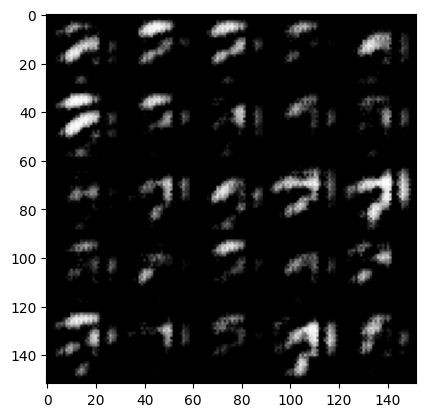

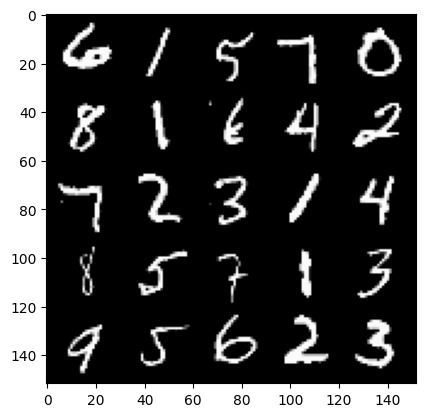

  4%|▍         | 2/50 [00:28<11:22, 14.22s/it]

Step 1000: Generator loss: 1.1110021854639054, Discriminator loss: 0.5238174614906311


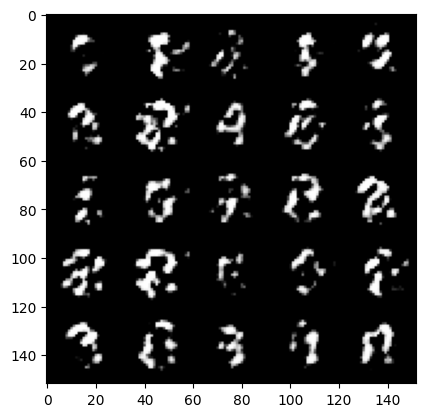

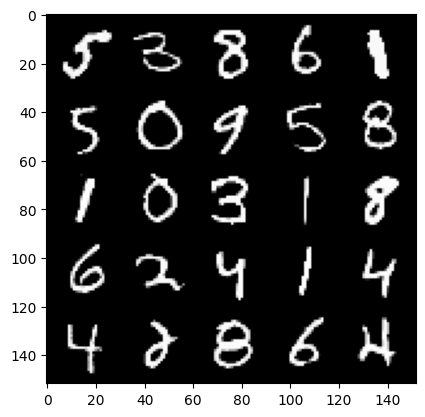

  6%|▌         | 3/50 [00:42<11:02, 14.09s/it]

Step 1500: Generator loss: 0.9122610782682896, Discriminator loss: 0.6075421025753022


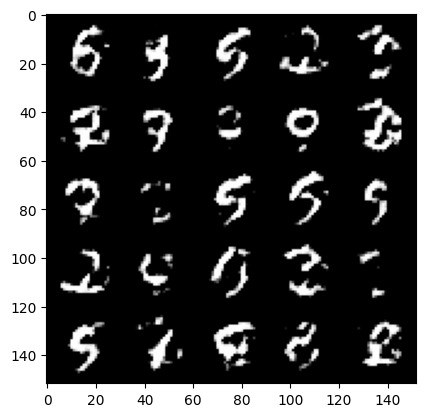

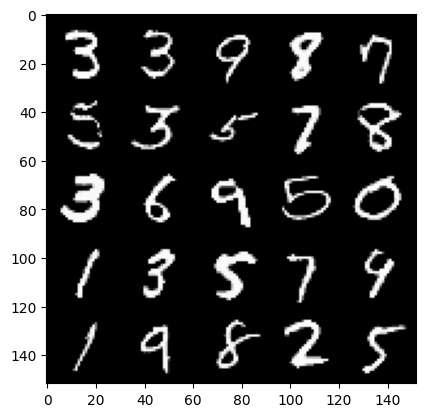

  8%|▊         | 4/50 [00:56<10:45, 14.03s/it]

Step 2000: Generator loss: 0.8449752041101456, Discriminator loss: 0.6211287578344346


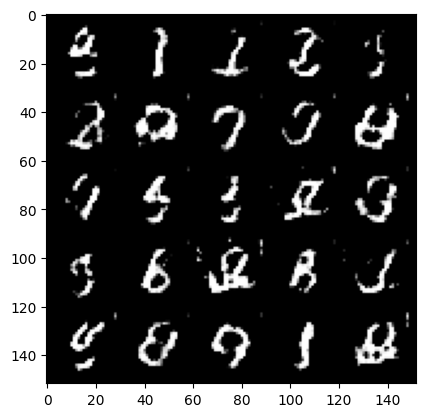

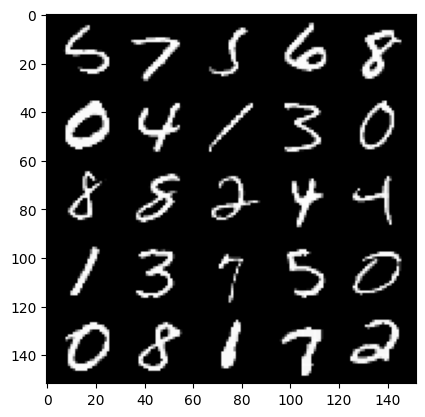

 10%|█         | 5/50 [01:10<10:34, 14.11s/it]

Step 2500: Generator loss: 0.8034290636181831, Discriminator loss: 0.6478325051069259


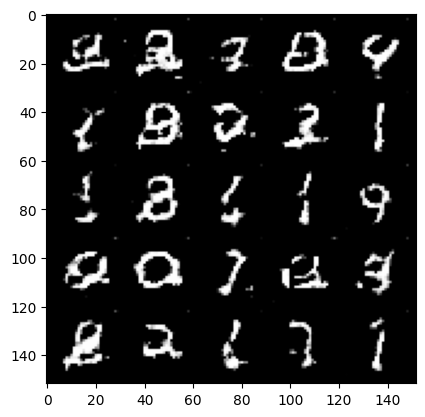

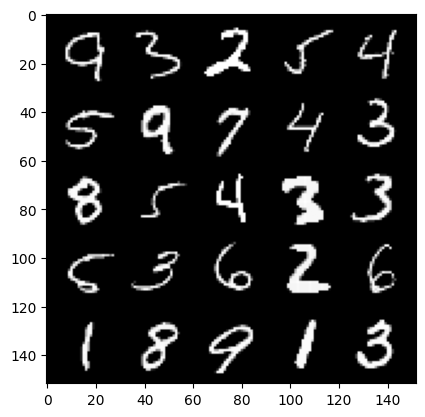

 12%|█▏        | 6/50 [01:24<10:19, 14.08s/it]

Step 3000: Generator loss: 0.7573026085495949, Discriminator loss: 0.6687159477472305


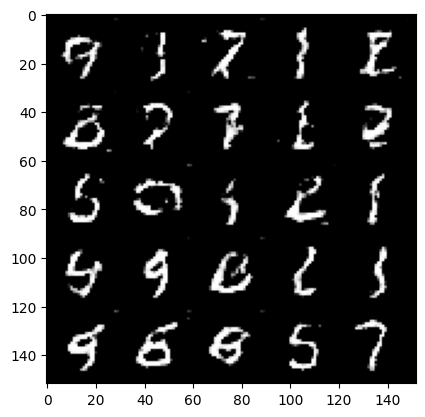

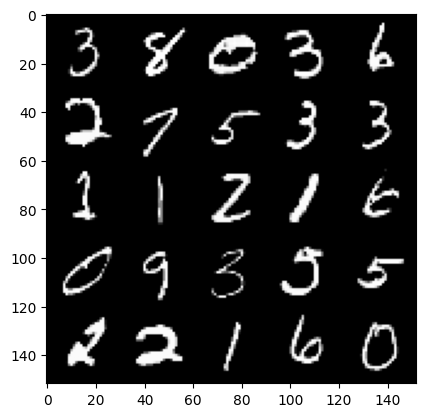

 14%|█▍        | 7/50 [01:38<10:07, 14.13s/it]

Step 3500: Generator loss: 0.7542781249284745, Discriminator loss: 0.6751932621002197


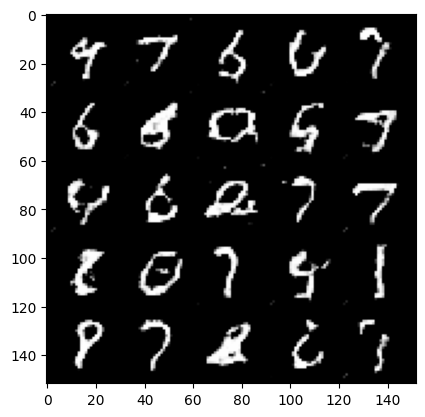

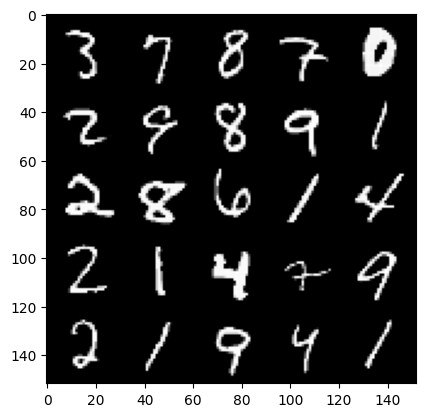

 16%|█▌        | 8/50 [01:52<09:52, 14.11s/it]

Step 4000: Generator loss: 0.7434686944484711, Discriminator loss: 0.6757919728755951


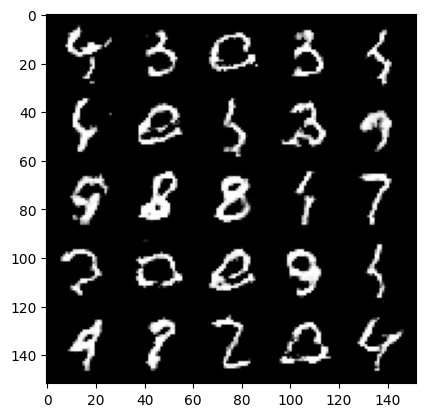

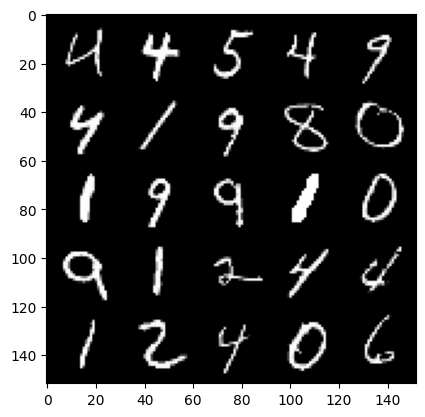

 18%|█▊        | 9/50 [02:07<09:39, 14.13s/it]

Step 4500: Generator loss: 0.7489301970005036, Discriminator loss: 0.6765503070354462


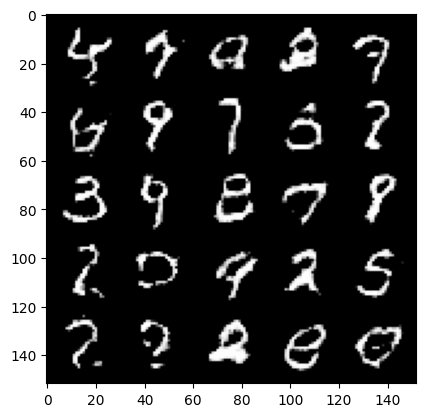

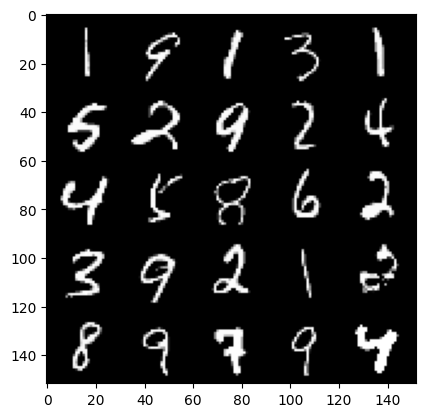

 20%|██        | 10/50 [02:21<09:24, 14.11s/it]

Step 5000: Generator loss: 0.7472845590114594, Discriminator loss: 0.6765289323329926


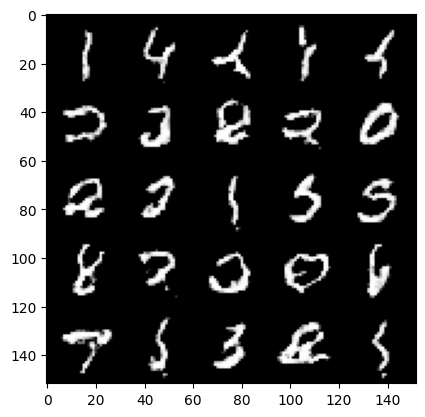

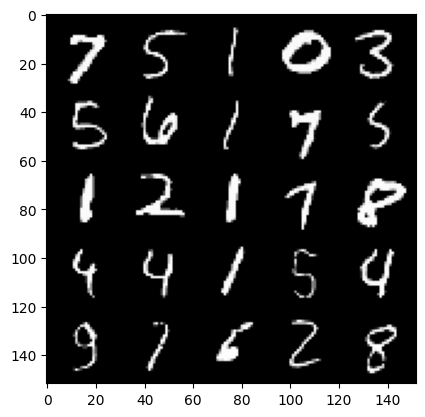

 22%|██▏       | 11/50 [02:35<09:10, 14.11s/it]

Step 5500: Generator loss: 0.7448097225427628, Discriminator loss: 0.6791117482185364


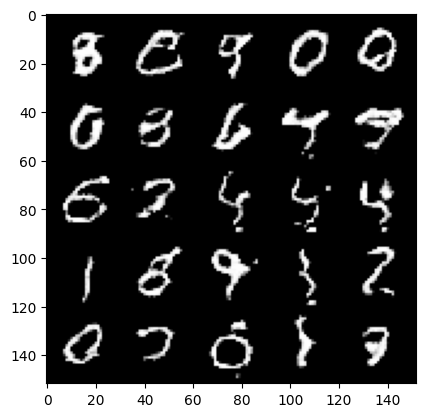

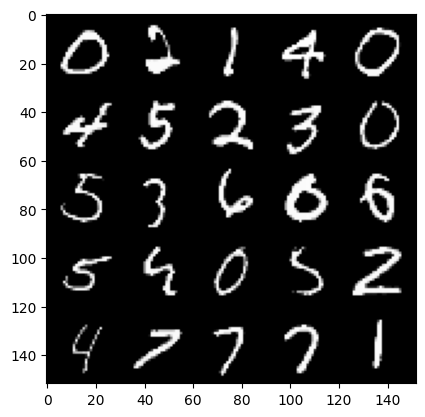

 24%|██▍       | 12/50 [02:49<08:57, 14.14s/it]

Step 6000: Generator loss: 0.7381244231462478, Discriminator loss: 0.6805675394535065


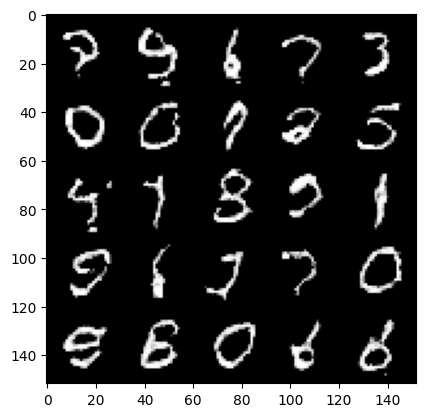

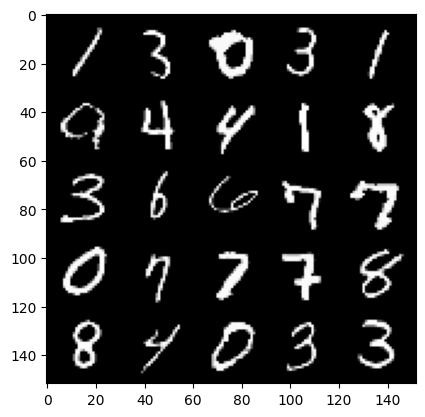

 26%|██▌       | 13/50 [03:03<08:46, 14.22s/it]

Step 6500: Generator loss: 0.7387191814184189, Discriminator loss: 0.6821635730266571


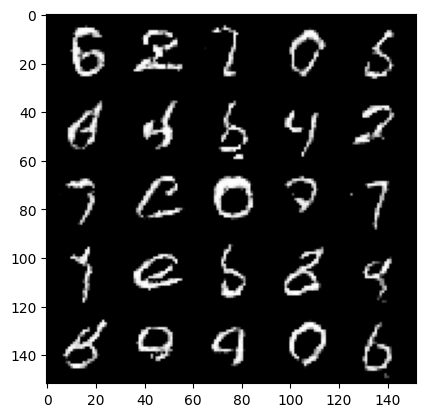

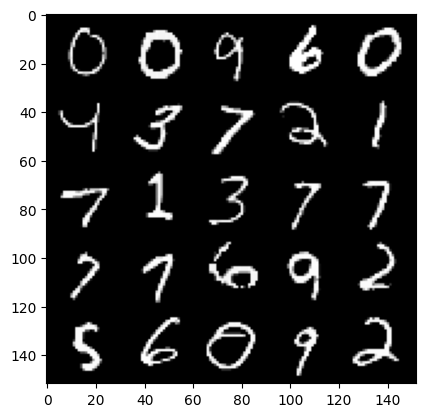

 28%|██▊       | 14/50 [03:18<08:33, 14.26s/it]

Step 7000: Generator loss: 0.7344060093164444, Discriminator loss: 0.6827180637121201


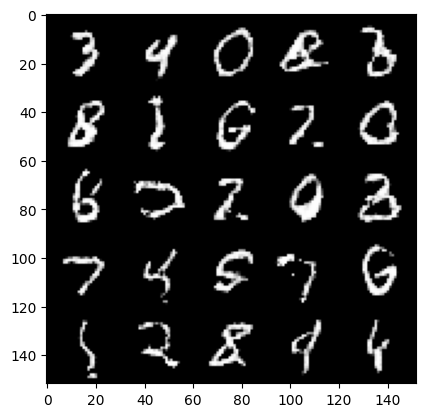

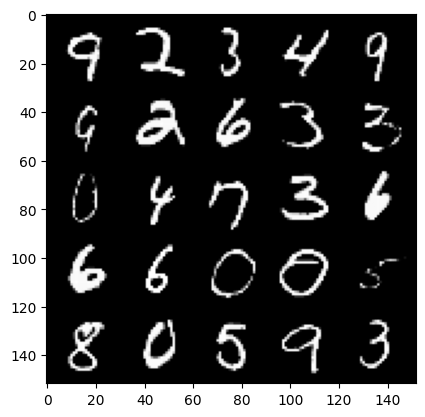

 30%|███       | 15/50 [03:32<08:18, 14.24s/it]

Step 7500: Generator loss: 0.7329436571598053, Discriminator loss: 0.6844412194490432


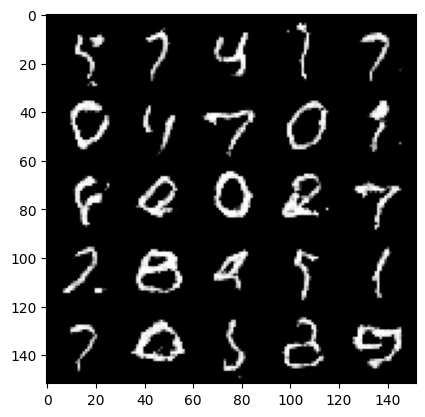

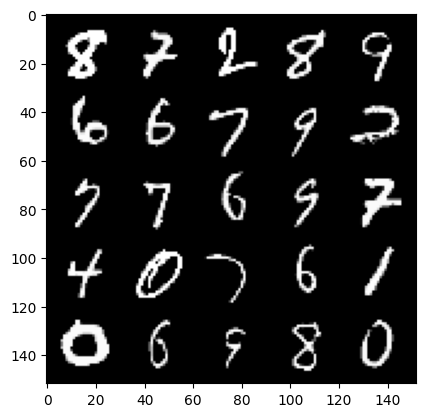

 34%|███▍      | 17/50 [04:00<07:45, 14.10s/it]

Step 8000: Generator loss: 0.729202064216137, Discriminator loss: 0.6851020084619522


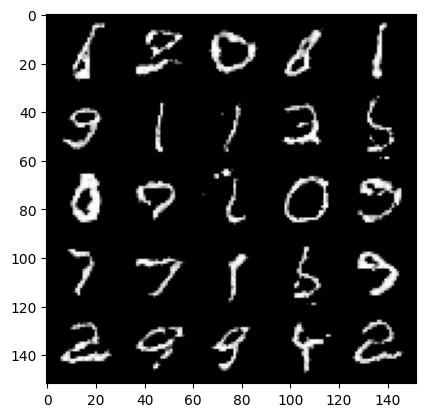

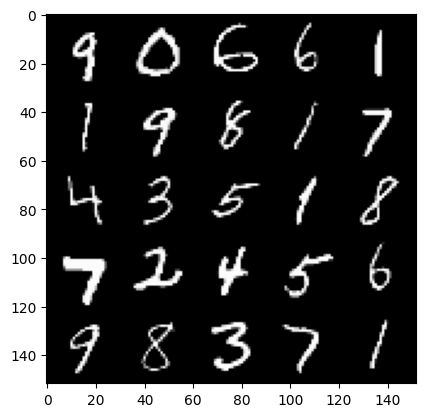

 36%|███▌      | 18/50 [04:14<07:33, 14.18s/it]

Step 8500: Generator loss: 0.7292620540261269, Discriminator loss: 0.6856991155147553


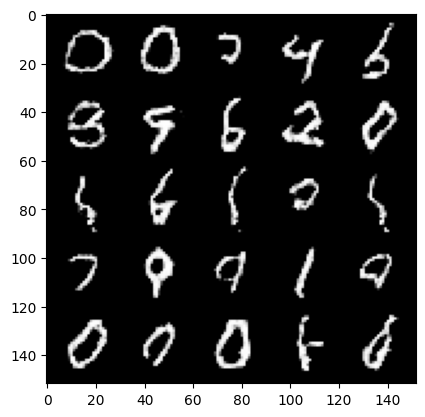

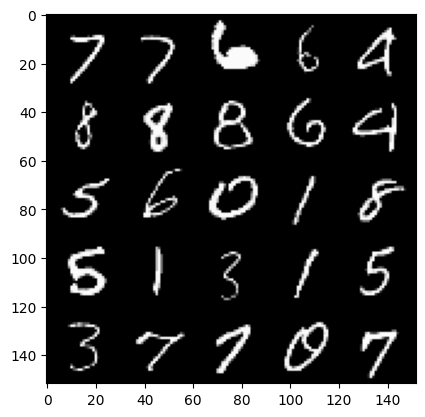

 38%|███▊      | 19/50 [04:29<07:19, 14.18s/it]

Step 9000: Generator loss: 0.7260562262535095, Discriminator loss: 0.6876964832544327


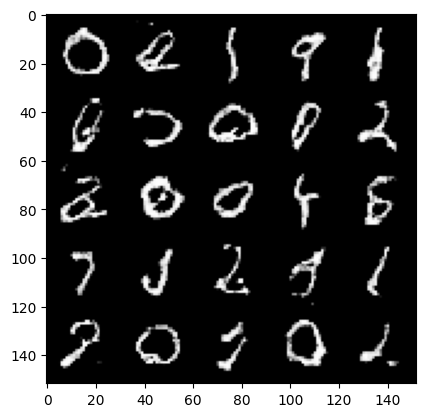

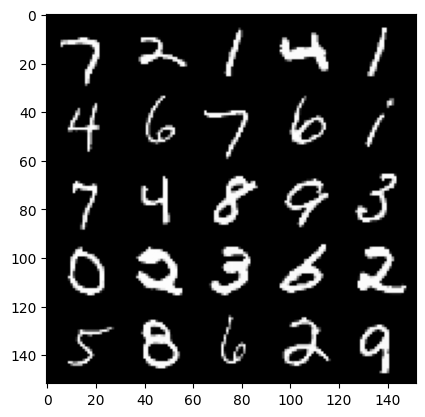

 40%|████      | 20/50 [04:43<07:05, 14.20s/it]

Step 9500: Generator loss: 0.7221902447938919, Discriminator loss: 0.6889912550449371


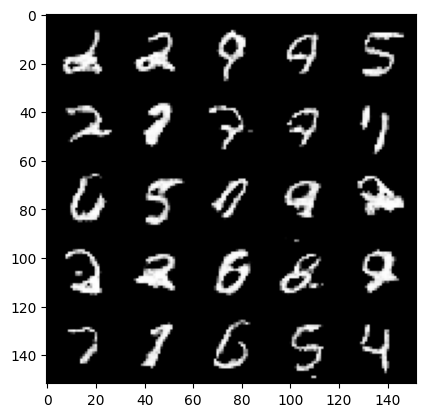

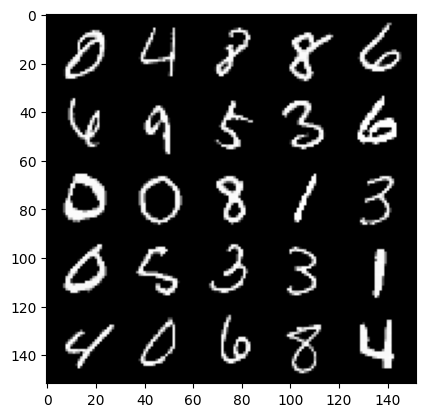

 42%|████▏     | 21/50 [04:57<06:51, 14.18s/it]

Step 10000: Generator loss: 0.721661371588707, Discriminator loss: 0.6887363215684891


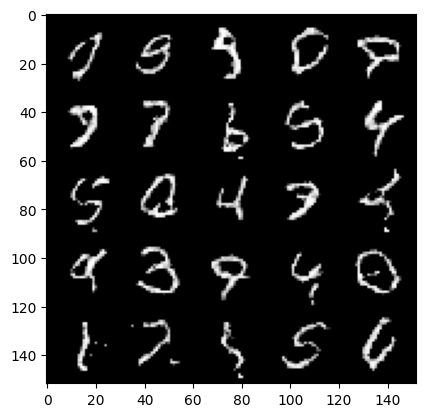

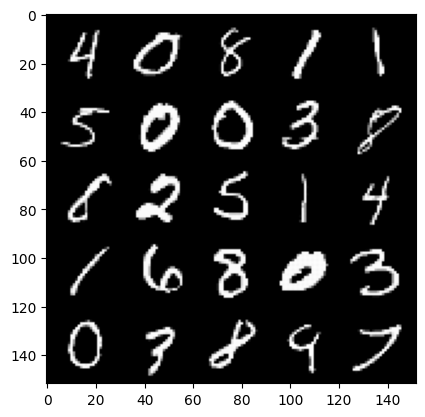

 44%|████▍     | 22/50 [05:11<06:37, 14.20s/it]

Step 10500: Generator loss: 0.7225581886768341, Discriminator loss: 0.6888680554628372


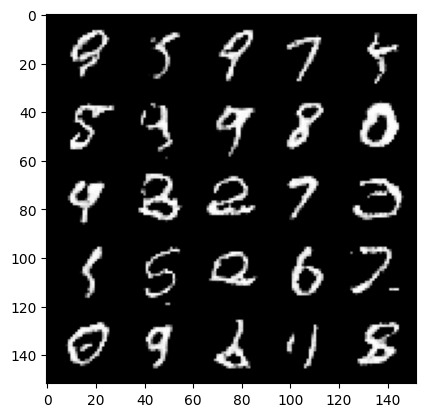

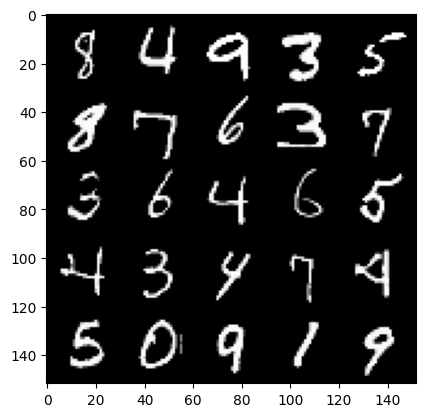

 46%|████▌     | 23/50 [05:25<06:23, 14.20s/it]

Step 11000: Generator loss: 0.7206747597455978, Discriminator loss: 0.6890157214403152


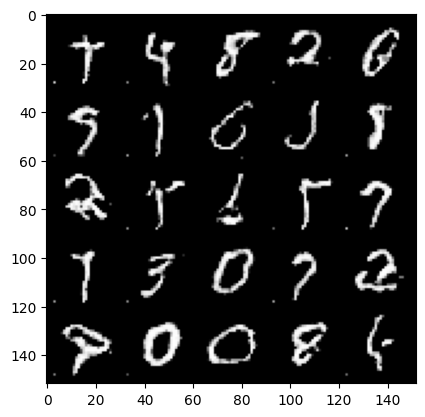

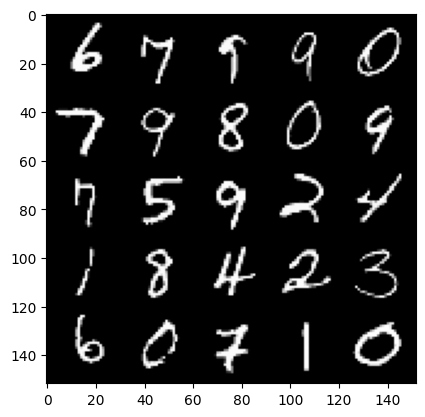

 48%|████▊     | 24/50 [05:40<06:10, 14.24s/it]

Step 11500: Generator loss: 0.7195823425650597, Discriminator loss: 0.6888041734695435


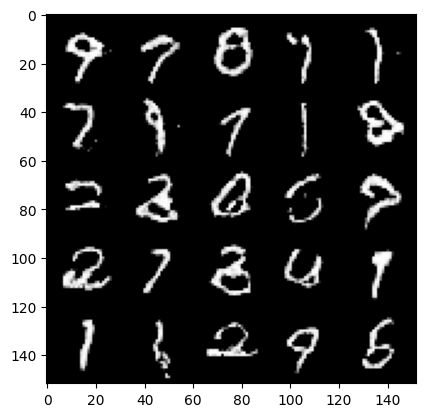

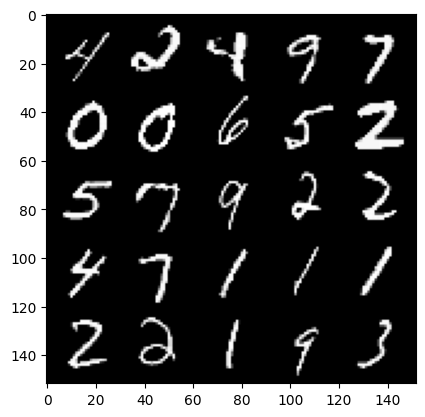

 50%|█████     | 25/50 [05:54<05:56, 14.25s/it]

Step 12000: Generator loss: 0.7195833014845848, Discriminator loss: 0.6895287489891052


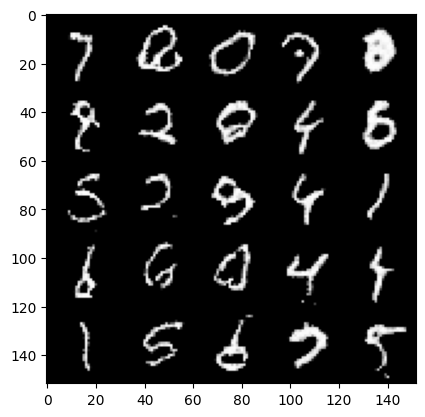

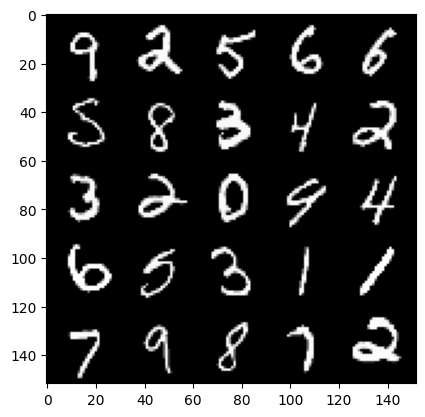

 52%|█████▏    | 26/50 [06:08<05:40, 14.21s/it]

Step 12500: Generator loss: 0.7186640119552612, Discriminator loss: 0.6896734341382981


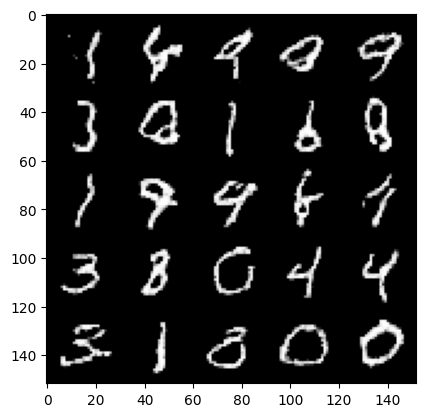

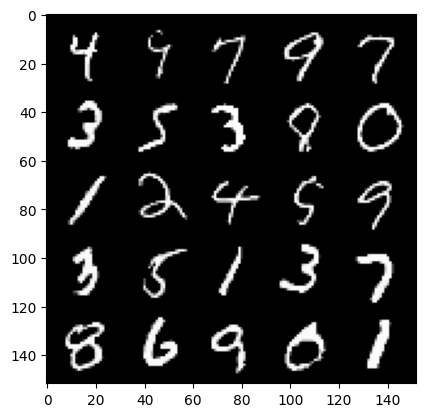

 54%|█████▍    | 27/50 [06:22<05:26, 14.19s/it]

Step 13000: Generator loss: 0.7133309181928634, Discriminator loss: 0.6921780165433884


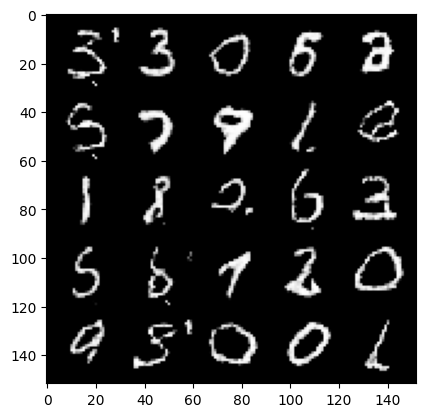

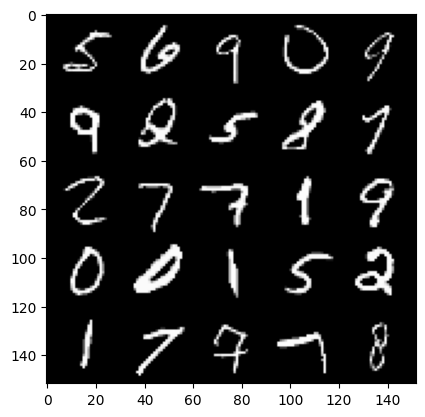

 56%|█████▌    | 28/50 [06:36<05:11, 14.17s/it]

Step 13500: Generator loss: 0.7121772422194481, Discriminator loss: 0.6920088769197464


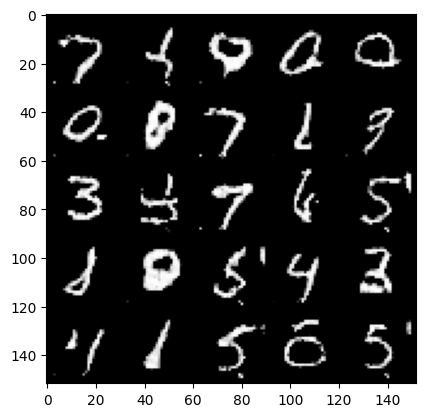

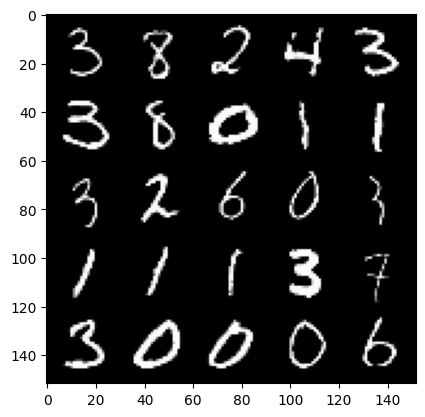

 58%|█████▊    | 29/50 [06:50<04:57, 14.16s/it]

Step 14000: Generator loss: 0.7104945690631866, Discriminator loss: 0.6926380187273026


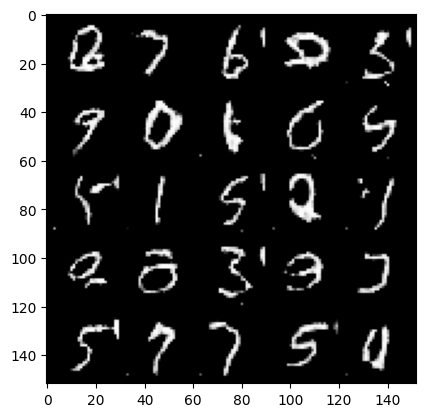

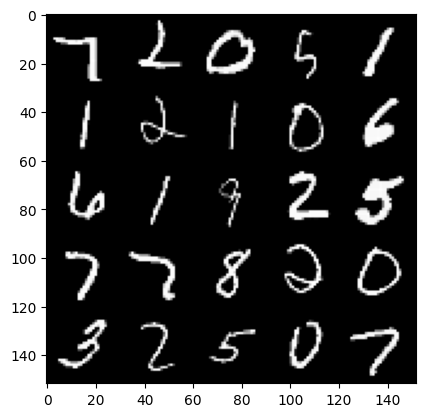

 60%|██████    | 30/50 [07:05<04:43, 14.15s/it]

Step 14500: Generator loss: 0.7086989641189575, Discriminator loss: 0.6928959344625473


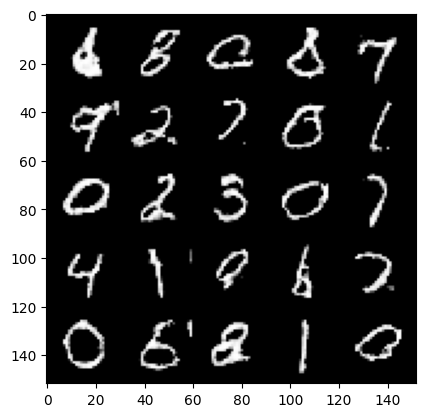

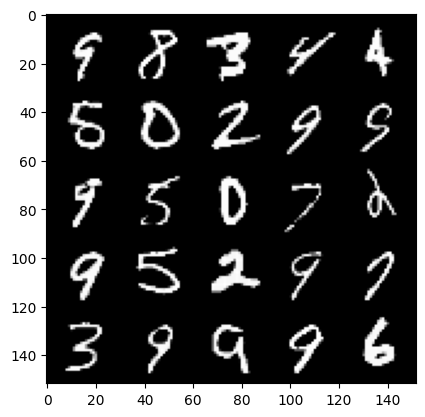

 62%|██████▏   | 31/50 [07:19<04:28, 14.15s/it]

Step 15000: Generator loss: 0.7079983053207397, Discriminator loss: 0.6934180935621261


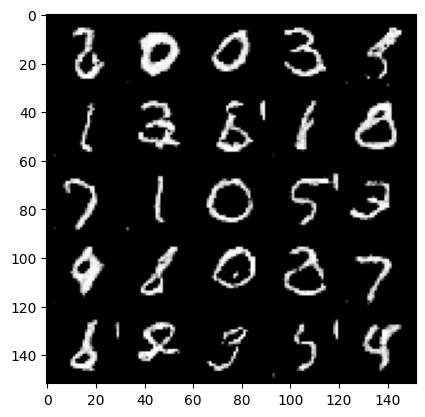

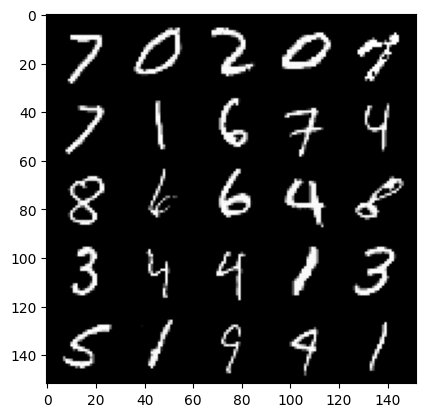

 66%|██████▌   | 33/50 [07:46<03:57, 13.96s/it]

Step 15500: Generator loss: 0.7092932212352753, Discriminator loss: 0.6941070172786713


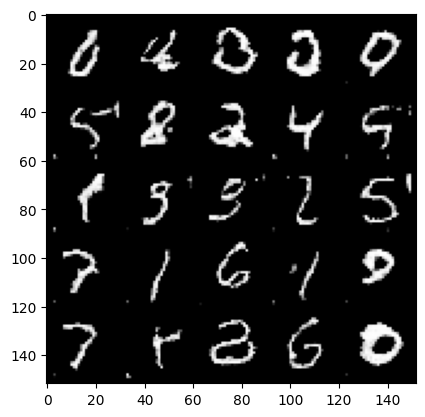

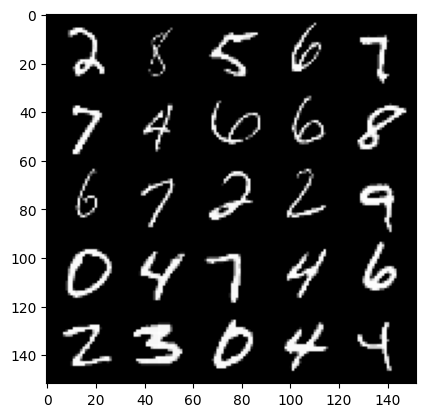

 68%|██████▊   | 34/50 [08:01<03:44, 14.05s/it]

Step 16000: Generator loss: 0.7082479444146156, Discriminator loss: 0.6938472344875336


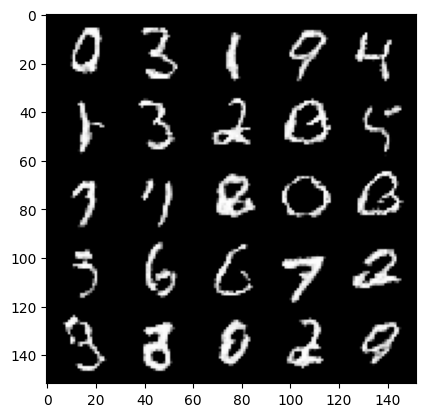

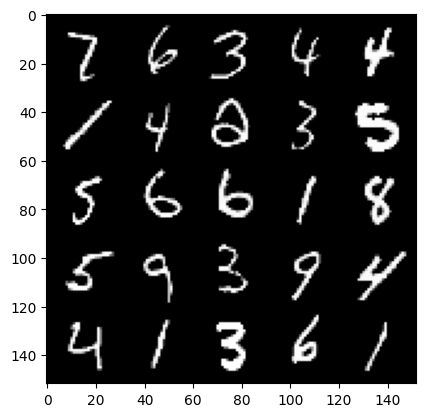

 70%|███████   | 35/50 [08:15<03:31, 14.10s/it]

Step 16500: Generator loss: 0.7065833058357239, Discriminator loss: 0.6937716972827911


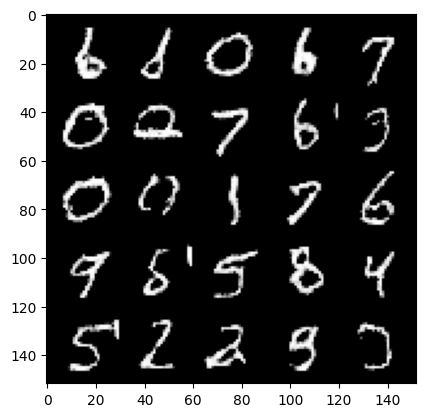

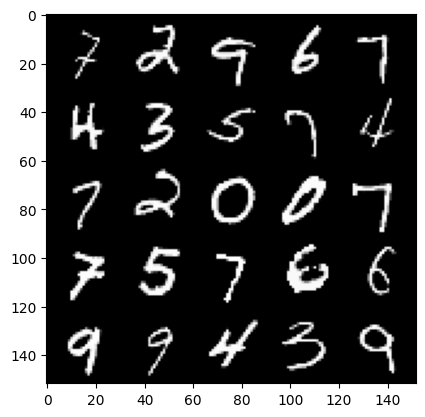

 72%|███████▏  | 36/50 [08:29<03:18, 14.15s/it]

Step 17000: Generator loss: 0.7052583239078521, Discriminator loss: 0.6942769259214401


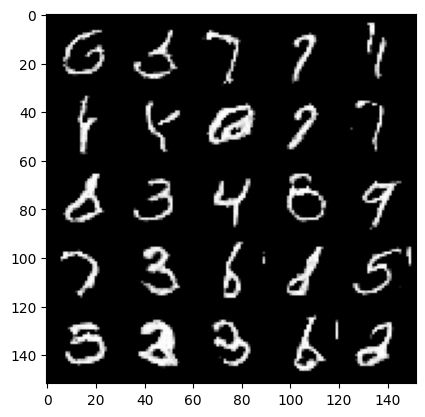

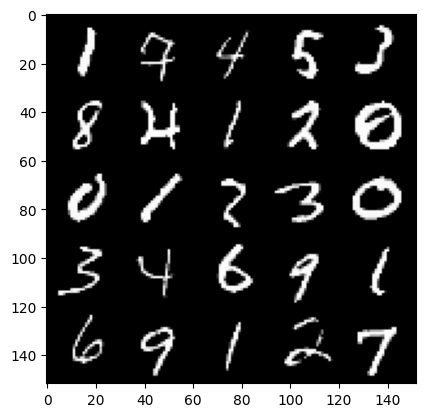

 74%|███████▍  | 37/50 [08:43<03:03, 14.12s/it]

Step 17500: Generator loss: 0.7048065763711929, Discriminator loss: 0.693535833477974


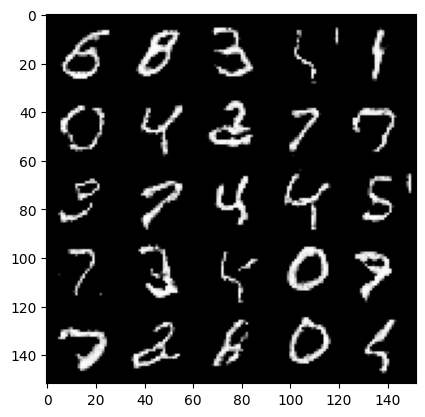

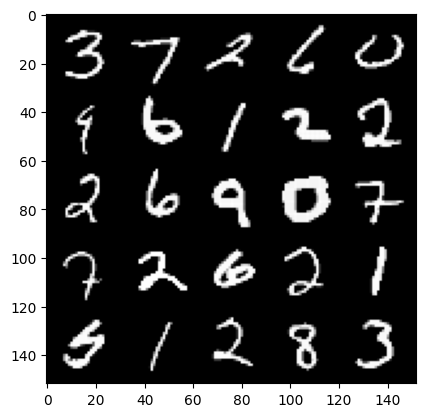

 76%|███████▌  | 38/50 [08:57<02:49, 14.14s/it]

Step 18000: Generator loss: 0.7069822680950165, Discriminator loss: 0.6935626158714294


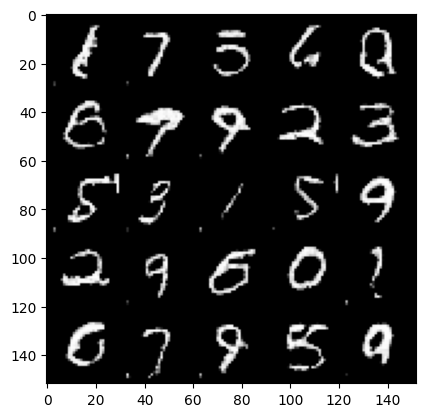

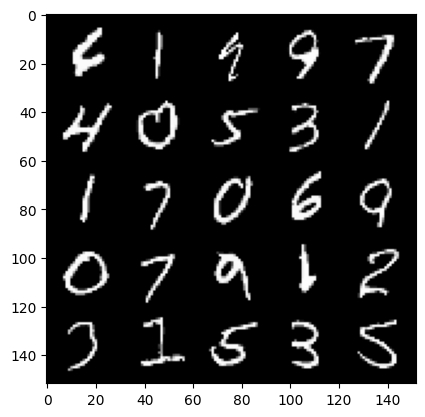

 78%|███████▊  | 39/50 [09:12<02:35, 14.14s/it]

Step 18500: Generator loss: 0.7052328462600708, Discriminator loss: 0.6936072661876679


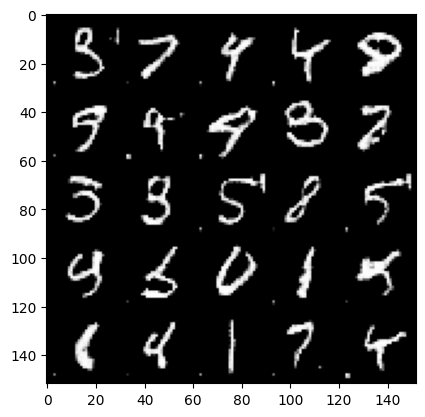

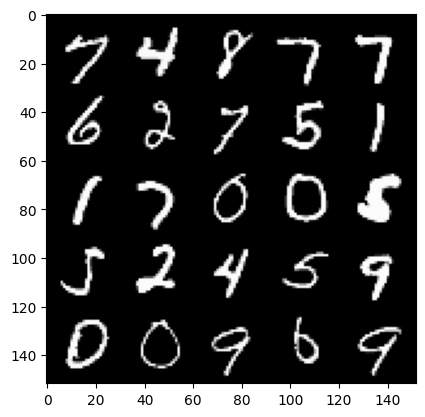

 80%|████████  | 40/50 [09:26<02:21, 14.13s/it]

Step 19000: Generator loss: 0.7051645919084549, Discriminator loss: 0.693884776711464


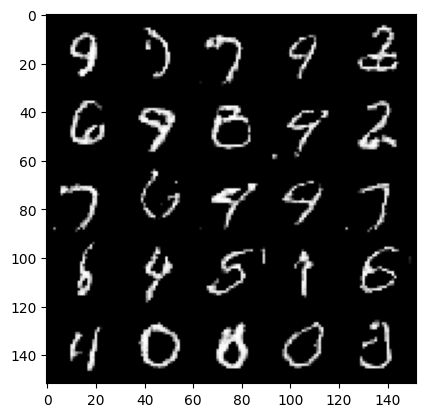

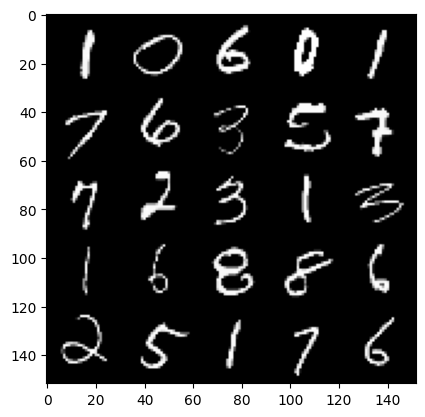

 82%|████████▏ | 41/50 [09:40<02:07, 14.18s/it]

Step 19500: Generator loss: 0.7040353262424469, Discriminator loss: 0.6938942165374756


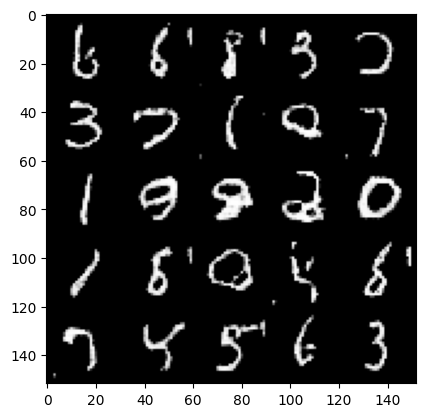

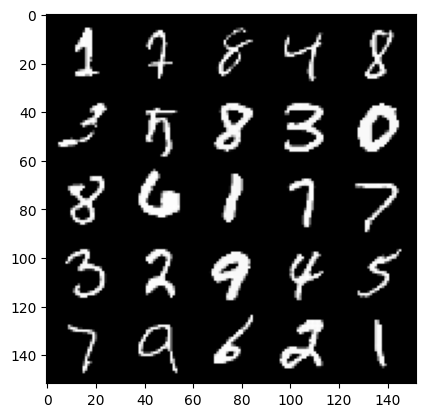

 84%|████████▍ | 42/50 [09:54<01:52, 14.12s/it]

Step 20000: Generator loss: 0.7021577272415161, Discriminator loss: 0.6937284742593766


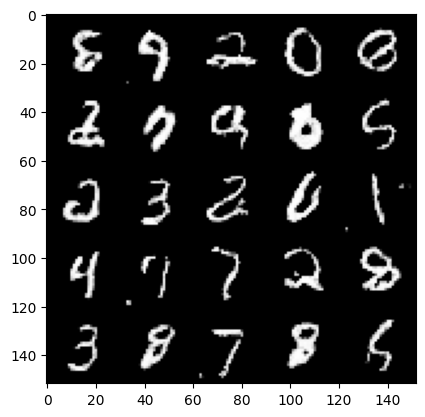

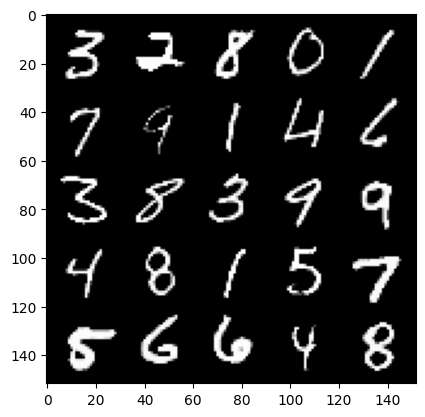

 86%|████████▌ | 43/50 [10:08<01:38, 14.11s/it]

Step 20500: Generator loss: 0.7037926615476608, Discriminator loss: 0.693926409959793


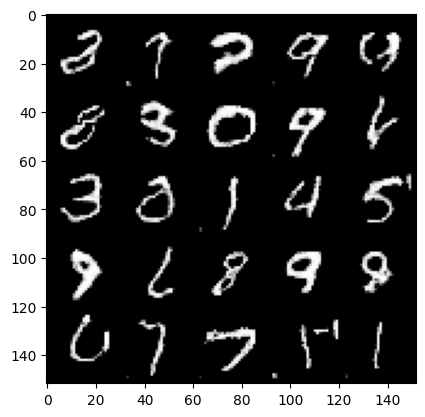

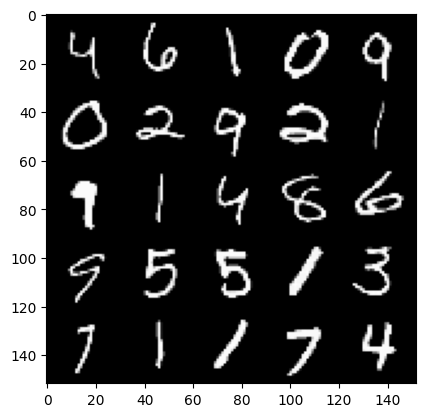

 88%|████████▊ | 44/50 [10:22<01:24, 14.05s/it]

Step 21000: Generator loss: 0.7033400000333786, Discriminator loss: 0.6940784324407577


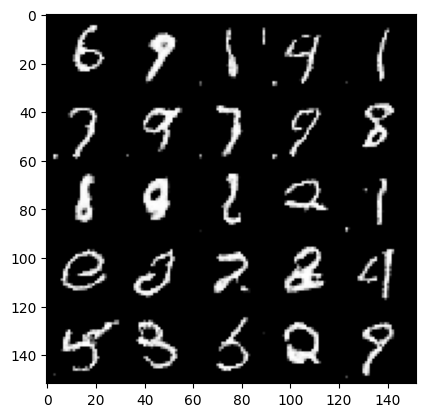

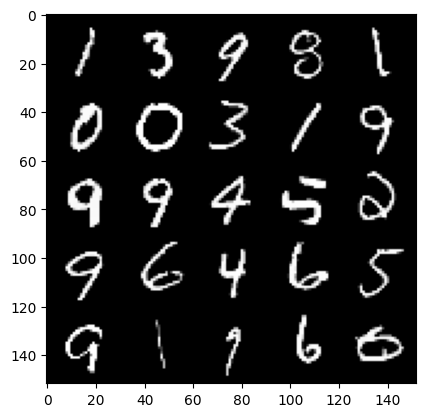

 90%|█████████ | 45/50 [10:36<01:10, 14.07s/it]

Step 21500: Generator loss: 0.7020861332416535, Discriminator loss: 0.6938912774324417


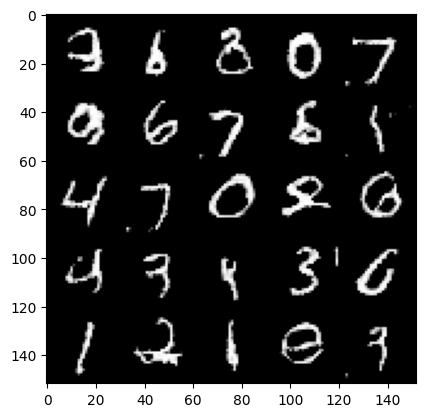

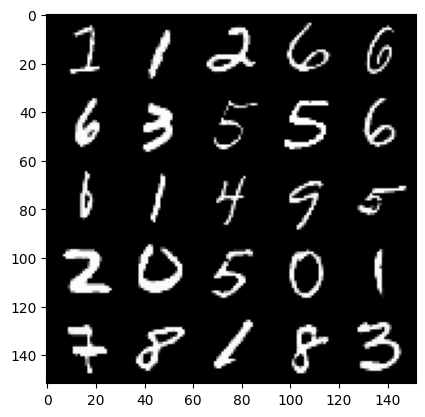

 92%|█████████▏| 46/50 [10:50<00:56, 14.07s/it]

Step 22000: Generator loss: 0.7023754031658173, Discriminator loss: 0.6944588227272034


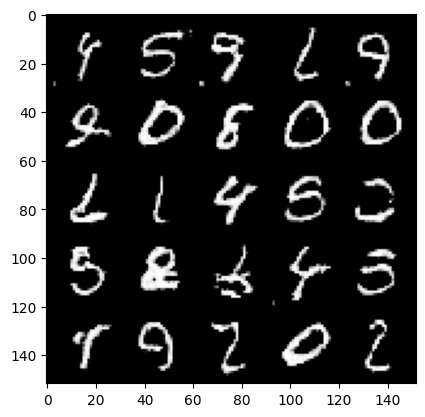

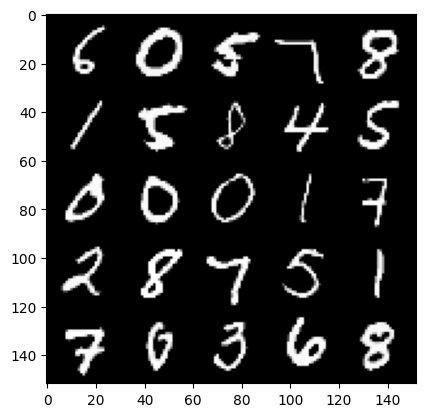

 94%|█████████▍| 47/50 [11:04<00:42, 14.04s/it]

Step 22500: Generator loss: 0.7022176550626755, Discriminator loss: 0.6938007826805115


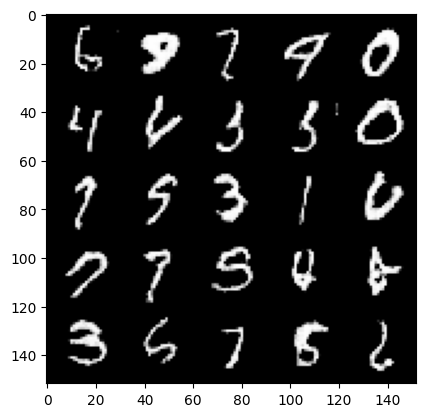

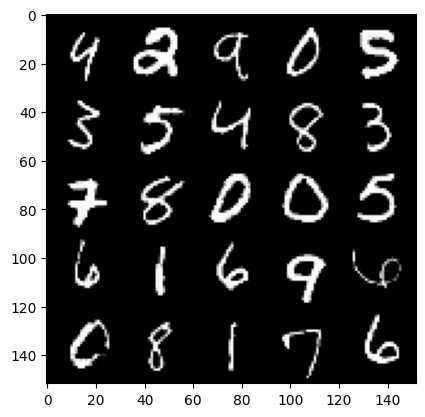

 98%|█████████▊| 49/50 [11:32<00:13, 13.94s/it]

Step 23000: Generator loss: 0.7014953622817993, Discriminator loss: 0.6941519575119018


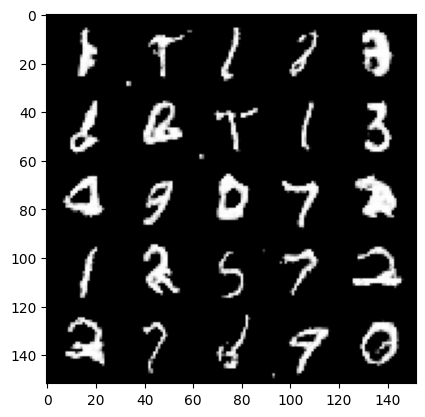

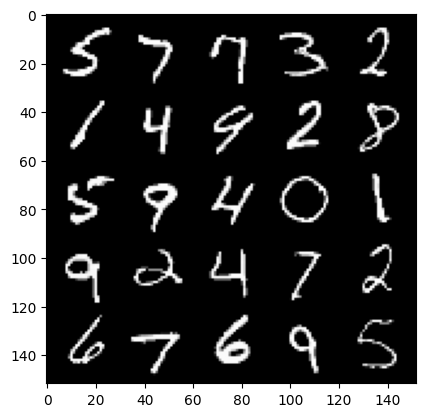

100%|██████████| 50/50 [11:46<00:00, 14.13s/it]


In [13]:
current_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
results = {
    "gen_train_loss": [],
    "disc_train_loss": [],
}

for epoch in tqdm(range(num_epochs)):
    
    # we iterate over the training dataloader
    # we only need the images, and not the labels
    for real_img, _ in train_loader:
        
        curr_batch_size = len(real_img)
        # No need to flatten the batch of real images,
        # as we're using DCGAN which uses convolutional layers
        real_img = real_img.to(device)

        # Update discriminator (Notice that we first train the discriminator)
        # Zero out the gradients before backpropagation
        optim_disc.zero_grad()
        # Calculate the discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real_img, curr_batch_size, z_dim, device)
        # Update gradients
        disc_loss.backward(retain_graph=True)  # we need to re-use the gradients for the generator
        # Update optimizer
        optim_disc.step()

        # Update generator
        # Zero out the gradients before backpropagation
        optim_gen.zero_grad()
        # Calculate the generator loss
        gen_loss = get_gen_loss(gen, disc, criterion, curr_batch_size, z_dim, device)
        # Update gradients
        gen_loss.backward()   # we have re-used the gradients for the generator, so no need to save the gradients
        # Update optimizer
        optim_gen.step()

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item()
        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item()

        # Visualization code
        if current_step % display_step == 0 and current_step > 0:
            mean_discriminator_loss = mean_discriminator_loss / display_step
            mean_generator_loss = mean_generator_loss / display_step
            results["gen_train_loss"].append(mean_generator_loss)
            results["disc_train_loss"].append(mean_discriminator_loss)
            print(f"Step {current_step}: Generator loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
            fake_noise = torch.randn(curr_batch_size, z_dim).to(device)
            fake_img = gen(fake_noise)
            plot_images(fake_img)
            plot_images(real_img)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        current_step += 1
        

**A note about image generation using DCGAN**

During training, you see 2 grids of MNIST digits displayed after every epoch. The first one shows fake digits produced by the generator and the second one shows the real images. You might be tempted to think that the generator is trying to mimic the real images and is attempting to *copy* the real images. But this is not true. What is actually happening is that we feed a noise vector to the generator that causes it to generate the fake images. So, the digits displayed might be different as they're randomly being generated by the generator. 

Note: The type of GAN we're using is a very basic version of the different variants of GANs present today. It does not have the capability to generate an image given some prompt. At this stage, it can only generate random images, given some input noise vector.

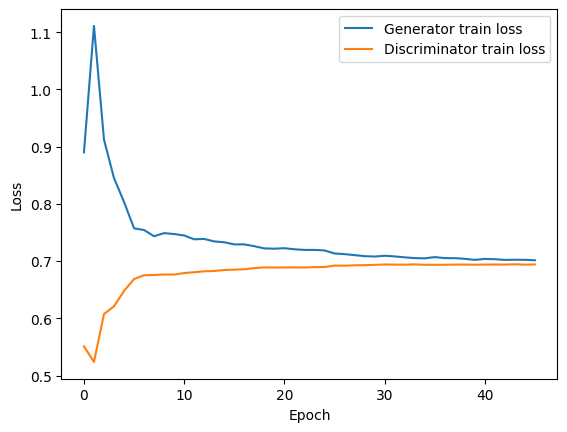

In [14]:
plot_results(results)